In [1]:
## Asad Ali
## MSDS-17008
## Due to Low Computational Resources, i will be working on 30% of the data. 
## It can always be changed on a high processing system.
## Thank U

In [2]:
##loading Required Libraries
%matplotlib inline
import os
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import math
from patsy import dmatrices
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.model_selection import StratifiedKFold, cross_val_score
from imblearn.over_sampling import SMOTE
from scipy.stats import randint as sp_randint
from sklearn.ensemble import BaggingClassifier

In [3]:
#import custom libraries
from importlib import reload
from pprint import pprint
import myclasses
reload(myclasses)
from myclasses import utils , MyDecisionTree, MyKFold
MyTree = MyDecisionTree()

Lets Load this Data into a Pandas Data Frame

In [4]:
#Loading CSV into memory
%time data = pd.read_csv('loan.csv', low_memory=False)
data.shape

Wall time: 50.1 s


(887379, 74)

So we got 887379 Objects with their 74 attributes. Lets see their attributes names

In [5]:
#data.columns

In [6]:
#Lets see the data now 
#data.head()

Now lets load data dictionary from the excel file given and lets try to match its description 

In [7]:
LCDataDictionary = pd.ExcelFile("LCDataDictionary.xlsx")
#open loanStats Sheet

attributeDescription  = {}
attributeDictionary  = {}

#capture columns data
LoanStats = LCDataDictionary.parse("LoanStats")
LoanStatNew = LoanStats['LoanStatNew'].tolist()
Description = LoanStats['Description'].tolist()

for i in range(len(LoanStatNew)):
    attributeDescription[LoanStatNew[i]] = Description[i]

browseNotes = LCDataDictionary.parse("browseNotes")
BrowseNotesFile = browseNotes['BrowseNotesFile'].tolist()
bDescription = browseNotes['Description'].tolist()

for i in range(len(BrowseNotesFile)):
    attributeDescription[BrowseNotesFile[i]] = bDescription[i]
    
    
# lets match it with out data columns
for column in data.columns:
    if column in attributeDescription:
        attributeDictionary[column] = attributeDescription[column]
    else:
        attributeDictionary[column] = ""

#So lets print this Data dictionary now
#attributeDictionary

<h1> Cleaning Data </h1>

Since we can see from data shape that there are multiple columns with 0 data so we should drop those columns first
The processes
1. Check if contains missing value
2. Check how much percentage missing value has
3. Delete columns with percentage of NaN more than 97% (Nan > 97%)

In [8]:

Cleaned_Data = data.copy()
MissingColumnDict = {}
TotalObjects = Cleaned_Data.shape[0]

for column in Cleaned_Data:
    
    nullCount = Cleaned_Data[column].isnull().sum();
    nullPercent = nullCount / (TotalObjects * 1.0)
    
    if nullCount > 0 and nullPercent > 0.97 :
        Cleaned_Data.drop(column, axis=1,inplace=True)
        MissingColumnDict[column] = nullPercent

In [9]:
print ('Columns Dropped with NaN > 97% are:')
#MissingColumnDict

Columns Dropped with NaN > 97% are:


I could see multiple n/a data in data so lets replace it with NaN and then lets replace it
Replace missing values with Unknown value or mean when feature is numerical

In [10]:
#Returns a random sample of items - 30% so the dataset is easy to work with
#Sampled_Data = Cleaned_Data.sample(frac = 0.3)
#Sampled_Data = Cleaned_Data.sample(frac = 0.1)
Sampled_Data = Cleaned_Data.copy()
Sampled_Data.shape

(887379, 57)

In [11]:
#Sampled_Data['emp_length'].value_counts()

Identifying Missing Data, Because Employement Length is required for Loan Operations so it is necessary

In [12]:

def CalculateEmployeeLength(year):
    if year == '< 1 year':
        return 0.5
    elif year == 'n/a':
        return 0.5
    elif year == '10+ years':
        return 10
    else:
        return float(year.rstrip(' years'))
        
Sampled_Data['emp_length_num'] = Sampled_Data.apply (lambda object: CalculateEmployeeLength(object['emp_length']),axis=1)
Sampled_Data = Sampled_Data.drop('emp_length',axis =1 )
Sampled_Data['emp_length_num'].value_counts()

10.0    291569
0.5     115430
2.0      78870
3.0      70026
1.0      57095
5.0      55704
4.0      52529
7.0      44594
8.0      43955
6.0      42950
9.0      34657
Name: emp_length_num, dtype: int64

Lets see the Attribute Loan Status of its attributes

In [13]:
#Sampled_Data['loan_status'].value_counts()

Now lets take only those Records which have Fully Paid or are defaulters

In [14]:
Sampled_Data = Sampled_Data[Sampled_Data['loan_status'].isin(['Fully Paid','Charged Off','Default'])]
Sampled_Data['loan_status'].value_counts()

Fully Paid     207723
Charged Off     45248
Default          1219
Name: loan_status, dtype: int64

In [15]:
# drop features that have no or little predictive power and original target
#Sampled_Data = Sampled_Data.drop(['id','member_id','url','desc','zip_code','policy_code','application_type','last_pymnt_d','last_credit_pull_d','verification_status','pymnt_plan','funded_amnt_inv','sub_grade','out_prncp','out_prncp_inv','total_pymnt_inv','total_pymnt','total_pymnt_inv','total_rec_prncp','total_rec_int','total_rec_late_fee','recoveries','collection_recovery_fee','last_pymnt_amnt','initial_list_status','earliest_cr_line'],axis =1)
Sampled_Data.replace('n/a', 'nan',inplace=True)
Sampled_Data.fillna('')

Sampled_Data['emp_title'].fillna('Unknown',inplace = True)
Sampled_Data['title'].fillna('Unknown',inplace = True)
Sampled_Data['revol_util'].fillna(Sampled_Data['revol_util'].mean(),inplace = True)
Sampled_Data['collections_12_mths_ex_med'].fillna(Sampled_Data['collections_12_mths_ex_med'].mean(),inplace = True)

# Drop those features which have more than 50% null values
features_missing_series = Sampled_Data.isnull().sum() > len(Sampled_Data)/5
features_missing_series = features_missing_series[features_missing_series == True]
features_missing_list =  features_missing_series.index.tolist()
Sampled_Data = Sampled_Data.drop(features_missing_list,axis =1)

Sampled_Data.isnull().sum()

id                              0
member_id                       0
loan_amnt                       0
funded_amnt                     0
funded_amnt_inv                 0
term                            0
int_rate                        0
installment                     0
grade                           0
sub_grade                       0
emp_title                       0
home_ownership                  0
annual_inc                      0
verification_status             0
issue_d                         0
loan_status                     0
pymnt_plan                      0
url                             0
purpose                         0
title                           0
zip_code                        0
addr_state                      0
dti                             0
delinq_2yrs                     0
earliest_cr_line                0
inq_last_6mths                  0
open_acc                        0
pub_rec                         0
revol_bal                       0
revol_util    

Lets Visualize The Data with Respect to Loan Amount


In [16]:
def CalculateLoanAmountBin(value):
    if value <= 5000:
      return '5K and Below'
    if value > 5000 and value <= 10000:
      return '5K-10K'
    if value > 10000 and value <= 15000:
      return '10K-15K'
    if value > 15000 and value <= 20000:
      return '15K-20K'
    if value > 20000 and value <= 25000:
      return '20K-25K'
    if value > 25000 and value <= 30000:
      return '25K-30K'
    if value > 30000 :
      return '30K and Above'
    return 'Other'

Sampled_Data['loan_amnt_bin'] = Sampled_Data.apply(lambda object: CalculateLoanAmountBin(object['loan_amnt']),axis=1)
Sampled_Data['loan_amnt_bin'].value_counts()

5K-10K           7430
10K-15K          5643
15K-20K          4020
5K and Below     3559
20K-25K          2371
25K-30K          1190
30K and Above    1107
Name: loan_amnt_bin, dtype: int64

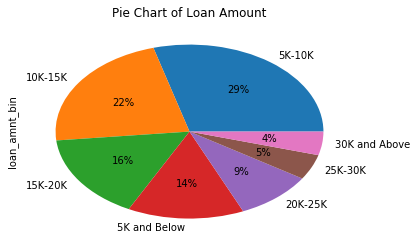

In [17]:
f = plt.figure(1)
Sampled_Data['loan_amnt_bin'].value_counts().plot.pie(autopct='%1.0f%%',)
plt.title('Pie Chart of Loan Amount')

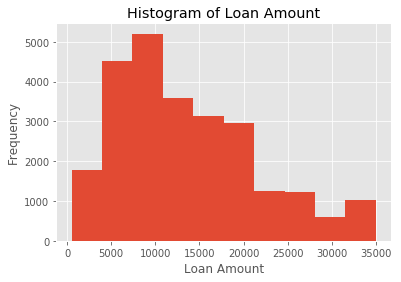

In [18]:
matplotlib.style.use('ggplot')
f = plt.figure(1)
Sampled_Data['loan_amnt'].hist()
plt.xlabel('Loan Amount')
plt.ylabel('Frequency')
plt.title('Histogram of Loan Amount')

Lets do the same for funded amount

In [19]:
Sampled_Data['funded_amnt_bin'] = Sampled_Data.apply (lambda object: CalculateLoanAmountBin(object['funded_amnt']),axis=1)
Sampled_Data['funded_amnt_bin'].value_counts()

5K-10K           7449
10K-15K          5667
15K-20K          4008
5K and Below     3569
20K-25K          2349
25K-30K          1183
30K and Above    1095
Name: funded_amnt_bin, dtype: int64

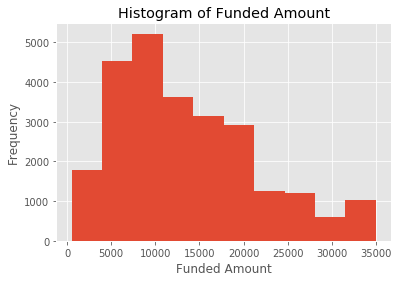

In [20]:
f = plt.figure(1)
Sampled_Data['funded_amnt'].hist()
plt.xlabel('Funded Amount')
plt.ylabel('Frequency')
plt.title('Histogram of Funded Amount')
plt.grid(True)

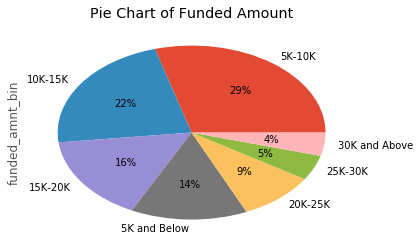

In [21]:
f = plt.figure(2)
Sampled_Data['funded_amnt_bin'].value_counts().plot.pie(autopct='%1.0f%%',)
plt.title('Pie Chart of Funded Amount')

Now lets see the Status of Loan

Now we need to find our positive and negative class which we want to predict. In this case Fully Paid is negative and  Late Loan is Positive Class.

In [16]:
def MarkLateLoan(status): 
    if status == 'Fully Paid':
        return 0
    else:
        return 1
    
Sampled_Data['Late_Loan'] = Sampled_Data.apply (lambda object: MarkLateLoan(object['loan_status']),axis=1)
Sampled_Data['Late_Loan'].value_counts()

0    207723
1     46467
Name: Late_Loan, dtype: int64

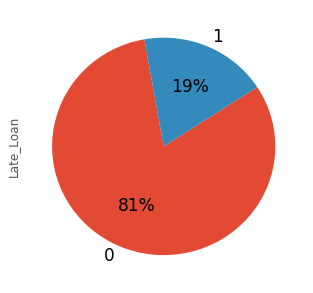

In [23]:
plt.figure(figsize=(5,5))
Sampled_Data['Late_Loan'].value_counts().plot(kind = 'pie',autopct='%.0f%%', startangle=100, fontsize=17)

Since Issue date is necessary so lets transform it

In [17]:
#transforming to date datatype
Sampled_Data['issue_d'] = pd.to_datetime(Sampled_Data.issue_d)

In [18]:
Sampled_Data.dtypes.value_counts()

float64           28
object            18
int64              3
datetime64[ns]     1
dtype: int64

Now lets apply operations for each dataType

In [26]:
Sampled_Data['purpose'].value_counts()

debt_consolidation    14792
credit_card            5134
home_improvement       1485
other                  1422
major_purchase          604
small_business          464
car                     392
medical                 261
moving                  210
wedding                 185
vacation                163
house                   149
educational              30
renewable_energy         29
Name: purpose, dtype: int64

By Showing it on Chart

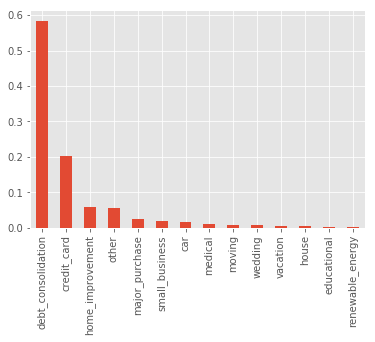

In [27]:
all_rows = Sampled_Data['purpose']
pur = Sampled_Data['purpose'].value_counts()
purp = pur/len(all_rows)
purp.plot(kind='bar')

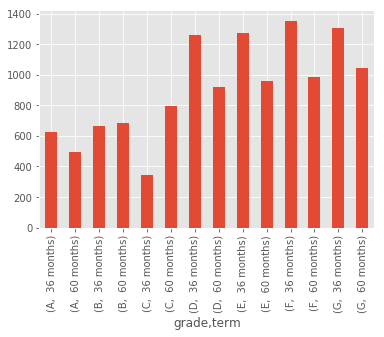

In [28]:
#I'm going to look at the installment payments against the grade and term of the loan.
#This pivot table shows the installment payments by grade and term.
loan_g = pd.pivot_table(Sampled_Data,
                           index= ['grade','term'],
                           columns= ['installment'] ,
                            values= 'loan_amnt',
                           aggfunc = sum)
loan_g.T.idxmax()
loan_g.T.idxmax().plot(kind='bar')

Now lets see the data with respect to House Ownership, normally if a person is on rent, it could be his problem of delaying and late payment

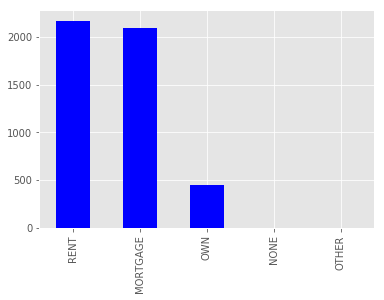

In [29]:
late = Sampled_Data[['home_ownership', 'Late_Loan']]
late_people = late['Late_Loan']== True
people = late[late_people]
people['home_ownership'].value_counts().plot(kind='bar', color= 'blue')

Lets Replace the Grade with a valid value which we can understand

In [19]:
def GradeInt(x):
    if x == "A":
        return 1
    elif x == "B":
        return 2
    elif x == "C":
        return 3
    elif x == "D":
        return 4
    elif x == "E":
        return 5
    else:
        return 6

Sampled_Data['GradeInt'] = Sampled_Data['grade'].map(GradeInt)
Sampled_Data['installmentAsPercent'] = Sampled_Data['installment']/(Sampled_Data['annual_inc']/12)

In [20]:
features = ['int_rate', 'GradeInt', 'loan_amnt', 'installment', 'annual_inc', 'dti',
       'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'collections_12_mths_ex_med',
       'acc_now_delinq', 'emp_length_num', 'installmentAsPercent'];
X = Sampled_Data[features]
Y = Sampled_Data["Late_Loan"]
X_columns = X.columns
sm = SMOTE(random_state=42)
X, Y = sm.fit_sample(X, Y)
X = pd.DataFrame(X,columns=X_columns)

In [32]:
X_train,X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.3)

In [21]:
X.shape

(415446, 17)

<h1>Scikit Learn Decision Tree</h1>

In [33]:
model = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth=14)
kfold = StratifiedKFold(n_splits= 10, shuffle = True)
scores = cross_val_score(model, X_train, Y_train, cv = kfold)

The Scores are as Follows

[ 0.82155232  0.81531532  0.82051282  0.82986833  0.82674983  0.82432432
  0.82744283  0.83679834  0.82350902  0.81969487]


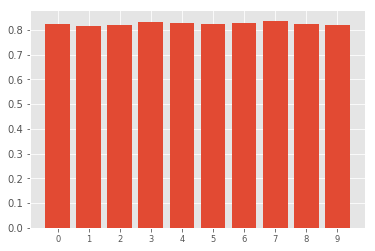

In [34]:
utils().print_scores(scores)

Lets train our classifier

In [35]:
best_model = model.fit(X_train, Y_train)
bagging = BaggingClassifier(best_model, random_state=1)
best_model.fit(X,Y)
predictions = best_model.predict(X_test)

In [36]:
print(X_train.shape)
print(X_test.shape)

(28856, 17)
(12368, 17)


Accuracy : 0.880174644243
Precision : 0.8317876559
recall : 0.923650568182
f1 Score : 0.875315497224

[[5202 1052]
 [ 430 5684]]


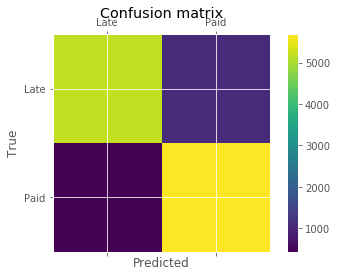

In [37]:
utils().print_metrics(predictions,Y_test)

Now lets use Bagging Classifer to predict the accuracy and precision etc
A Bagging classifier is an ensemble meta-estimator that fits base classifiers each on random subsets of the original dataset and then aggregate their individual predictions (either by voting or by averaging) to form a final prediction. Such a meta-estimator can typically be used as a way to reduce the variance of a black-box estimator (e.g., a decision tree), by introducing randomization into its construction procedure and then making an ensemble out of it.


# My Decision Tree and KFold

In [22]:
train,test = MyTree.train_test_split(X ,Y, test_size = 0.5)

In [23]:
target = 'Late_Loan'
attribute_names = list(train.columns)
attribute_names.remove(target)

In [24]:
#train = train.sample(frac=0.3)
print(train.shape)
#test = test.sample(frac=0.3)
print(test.shape)

(207723, 18)
(207723, 18)


In [25]:
%time tree = MyTree.fit(train, attribute_names)

Wall time: 6min 31s


### Tree Structure

if you want to see the Tree, uncomment below

In [42]:
#pprint(tree)

In [26]:
%time predictions = MyTree.predict(test)

Wall time: 1min 27s


Accuracy : 0.503742965391
Precision : 0.975203817472
recall : 0.501091952311
f1 Score : 0.662017455852

[[100957   2567]
 [100517   3682]]


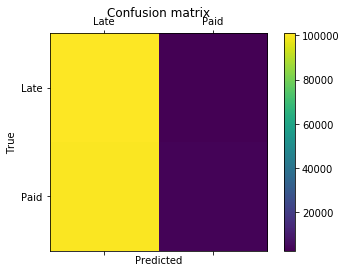

In [27]:
actual = test['Late_Loan']
utils().print_metrics(predictions,actual)

## KFold

In [28]:
scores = MyKFold().predict(data = test, n_splits= 10, model = MyTree, shuffle = True)

[0.97592274539032375, 0.97580697328417099, 0.97425736194342416, 0.97576090113933445, 0.97522493154257395, 0.97615441626655497, 0.97514138735342049, 0.97502574665293507, 0.97420309434205021, 0.97559477631238689]


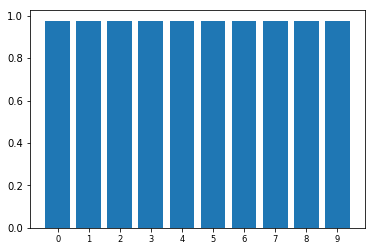

In [29]:
utils().print_scores(scores)